In [1]:
# Python libraries
import os
import sys
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
import matplotlib.pyplot as plt

# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Import custom functions from other notebooks
sys.path.append("myfun/")
from ipynb.fs.full.myfun_model_nn import *
from ipynb.fs.full.myfun_density import *

2024-02-27 22:07:03.852806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 22:07:03.852835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 22:07:03.853788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 22:07:03.860128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 22:07:04.818881: W tensorflow/compiler/tf2

# Preliminary

In [2]:
## Params
Nx = 200
Nt = 160
T = 0.5

In [3]:
# Space - linearly distributed
dx = 1/int(Nx/3)
a = np.linspace(-1,0,int(Nx/3))
b = np.linspace(0+dx/2, 1, Nx-int(Nx/3))
xspan = np.concatenate([a, b])
cons_dis = np.diff(xspan, axis=0)

# Time
tspan = np.linspace(0,T,Nt)

## Exact density

In [4]:
## Params
rho_l = 0.4
rho_r = 0.8
rho_out = 0

In [5]:
## Flux
#Traffic Jam
f = lambda rho: rho*(1-rho)  
fprime = lambda rho: 1-2*rho
fprime_inv = lambda rho: .5*(1-rho)

# params
toll = 1e-3
flux = [f, fprime, fprime_inv]
speed_shock = (f(rho_r) - f(rho_l))/(rho_r - rho_l)

In [6]:
## plot params
N = 50 # how many chars, cars trajs to compute
xlims = [-1,1] # computational x limits
drho = 0.2
xlim1, xlim2 = -1.25, 1.75 # plot x limits

# # t to plot
# idx = 0, int(len(tspan)*.5), -1

# Plot trajs with NN

In [7]:
dir_nn2 = "2023-12-09_21-54-43_df1-2-3-4-5-6-7-8-9-10_500it-PRE-nn2"
dir_nn4 = "2023-12-10_01-23-07_df1-2-3-4-5-6-7-8-9-10_500it-PRE-nn4"
dir_nn10 = "2023-12-10_11-38-47_df1-2-3-4-5-6-7-8-9-10_500it-PRE-nn10"

namefile_model_nn = "/model_nn2.keras"

In [8]:
## preliminaries
dir_nn = dir_nn2
target_dir = "./out/"
path = target_dir + dir_nn

In [9]:
## Load model
model_nn = keras.models.load_model(path + namefile_model_nn)

In [10]:
# ## Load info
# namefile_nn = "/info_nn1.txt"
# # Construct a list for header
# with open(path + namefile_nn) as f:
#     header = f.readline().split(sep=',')
# header[-1] = header[-1].split("\n")[0]
# info_nn = pd.read_csv(path + namefile_nn, sep=',', usecols= header)

In [11]:
## Compute the velocities
y_pred = model_nn(cons_dis, training=False)

## Approximate the velocity of the leading car ?
v0 = y_pred.numpy().mean()
vel_nn = y_pred.numpy().flatten().tolist() + [v0]

# check
if all(i >= v0 for i in y_pred):
    print("There is at least a vehicle faster than the leading car") 
    
# Solve the ODE system in this time interval
sol_ann = odeint(TD_ANN_model, xspan, tspan, args=(vel_nn,), tfirst=True).T

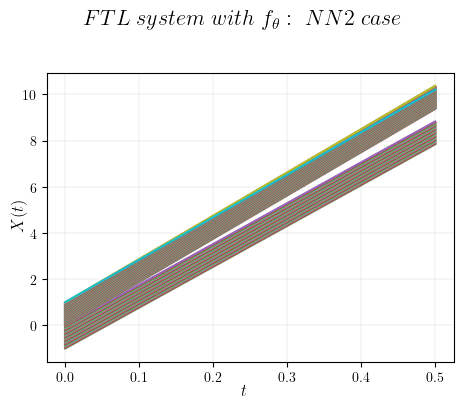

In [12]:
# Initialize the fig
nrow, ncol = 1, 1
width, height = 7, 5 # single subplot
fig, ax = plt.subplots(nrow,ncol,figsize=(width*ncol*.75,height*.75))

# Plot the true and simulated trajectories for each vehicle
for veh in range(0, Nx):
    ax.plot(tspan, sol_ann[veh])

ax.grid(color='grey', linestyle='-', linewidth=0.1)

plt.suptitle(fr"$FTL\ system\ with\ f_\theta:\ NN2\ case$", fontsize=16,y=1.05);
fig.supxlabel("$t$", x= 0.5)
fig.supylabel("$X(t)$", x =0.055)
plt.show()

In [13]:
def isincreasing(x):
    
    dx = np.diff(x)
    idx_nm = []
    result = np.all(dx >= 0)
    
    if not result:
        for i in range(len(x)-1):
            if x[i] > x[i+1]:
                idx_nm.append(i)
                
    return result, idx_nm

# Plot discretized density

In [14]:
## PARAMS
ln = 1/Nx
idx = 0, int(len(tspan)*.5), -1
# idx = 0, 10, 20

# exact plot
exact_flag = False

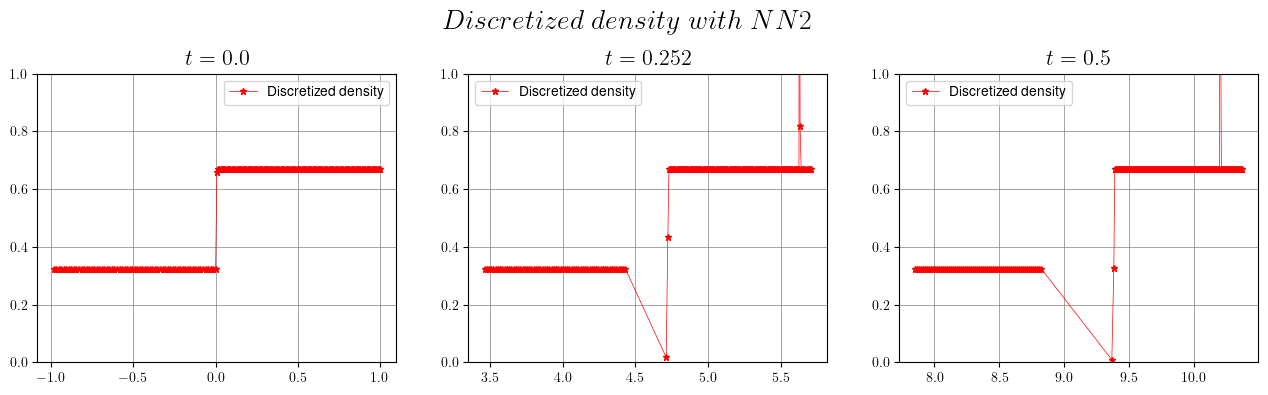

In [15]:
# Initialize the fig
nrow, ncol = 1, 3
width, height = 7, 5 # single subplot
fig, axes = plt.subplots(nrow,ncol,figsize=(width*ncol*.75,height*.75))

fig.suptitle(fr"$Discretized\ density\ with\ NN2$", fontsize=20, y = 1.05); # Figure titles


for ax, i in zip(axes, idx):
    
    t = tspan[i]

    # exact density
    if exact_flag:
        idx_t, (cp_t, d_t), _, _ = rho_2s(xlims, N, tspan, rho_l, rho_r, rho_out, flux, np.round(t,8), drho)
        ax.plot(cp_t, d_t, c='g', ls = '-', lw = .5, marker='*', label="Exact density")
        if i != idx_t:
            print("warning: time stamps for exact and lin/log density don't match!")
    
    # NN solution
    car_pos = sol_ann[:,i]
    car_pos.sort()
    
    x = car_pos[1:]
    # Discretized density
    ln = 1/Nx
    rho_dis = ln/(np.diff(car_pos, axis=0))
    
    # NN solution
    x = sol_ann[:,i][1:]
    ax.plot(x,rho_dis,c='red', ls='-', lw = 0.5, ms=5, marker='*', label="Discretized density")
#     ax.plot(x,x*0,c='blue', ls='', ms=5, marker='o', label="Particles")

    ax.set_ylim([0, 1])
    ax.set_title(fr"$t={t.round(3)}$",fontsize=16)

    ax.grid(color='grey', linestyle='-', linewidth=0.5)
    ax.legend()

plt.show()

# Fixing...

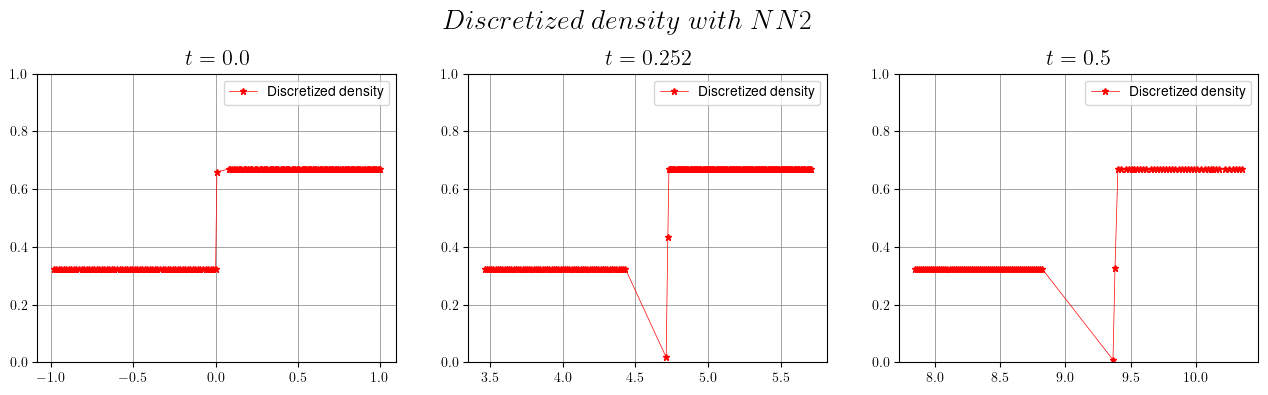

In [16]:
# Initialize the fig
nrow, ncol = 1, 3
width, height = 7, 5 # single subplot
fig, axes = plt.subplots(nrow,ncol,figsize=(width*ncol*.75,height*.75))

fig.suptitle(fr"$Discretized\ density\ with\ NN2$", fontsize=20, y = 1.05); # Figure titles


for ax, i in zip(axes, idx):
    
    t = tspan[i]

    # exact density
    if exact_flag:
        idx_t, (cp_t, d_t), _, _ = rho_2s(xlims, N, tspan, rho_l, rho_r, rho_out, flux, np.round(t,8), drho)
        ax.plot(cp_t, d_t, c='g', ls = '-', lw = .5, marker='*', label="Exact density")
        if i != idx_t:
            print("warning: time stamps for exact and lin/log density don't match!")
    
    # NN solution
    car_pos = sol_ann[:,i]
    car_pos.sort()
    
    x = list(car_pos[1:])
    # Discretized density
    ln = 1/Nx
    rho_dis = list(ln/(np.diff(car_pos, axis=0)))
    
    # Cutting off values over 1
    x_fixed, rho_dis_fixed = x.copy(), rho_dis.copy()
    j, rhomax = 0, rho_dis[-20]
    while j<len(rho_dis_fixed):
        if rhomax-rho_dis_fixed[j] < 0:
            rho_dis_fixed.pop(j), x_fixed.pop(j)
            j = j-1
        j+=1
        
    # NN solution
    ax.plot(x_fixed,rho_dis_fixed,c='r', ls='-', lw = 0.5, ms=5, marker='*', label="Discretized density")

#     ax.plot(x,x*0,c='blue', ls='', ms=5, marker='o', label="Particles")

    ax.set_ylim([0, 1])
    ax.set_title(fr"$t={t.round(3)}$",fontsize=16)

    ax.grid(color='grey', linestyle='-', linewidth=0.5)
    ax.legend()

plt.show()